# Importing Libraries

We are going to import the following libraries

In [20]:
import os
import numpy as np
from glob import glob
import pandas as pd

import string

from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import nltk
from nltk import FreqDist

from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Functions

In the next section, we need to do some data cleaning, checking the null values of each row , and join each token to make a cleaned text.

In [2]:
def new_cleaning(data):


    cleaned_data = data.replace("[", "").replace("]", "").replace("'", "")\
                                    .replace(" ", "").split(",")
    
    
    return cleaned_data

In [3]:
def null_finder(row):
    if type(row) is dict:
        a = row.values()
        row = sum([int(bool(item)) for item in a])
    elif type(row) is list:
        row = sum([int(bool(item)) for item in row])
    else:
        row = int(row is np.nan)
    return row

# Importing Tokenized Data

In this section, we will import the data that we cleaned in "EDA-part-1-Cleaning-Tokenization-Lammatization" notebook and will concatenate all the dataframes to each other to make one dataframe. Also, we will shuffle the rows to make sure that the data are shuffled in the dataframe. 

In [4]:
csv_files = glob("./cleaned/*.csv")
csv_files

csv_files_dict = {}
for filename in csv_files:
    filename_cleaned = (os.path.basename(filename)
                          .replace(".csv", "")
                          .replace(".", "_"))  #cleaning the filenames
    filename_df = pd.read_csv(filename, index_col=0)
    csv_files_dict[filename_cleaned] = filename_df
all_df ={}
for item in csv_files_dict:
    all_df[item] = csv_files_dict[item].drop_duplicates().reset_index(drop=True)
    
    
print("DONE!")    

DONE!


In [5]:
for item in all_df:
    all_df[item]["is_null"] = all_df[item]["cleaned"].apply(lambda x: null_finder(x))
    print(item, len(all_df[item].loc[all_df[item]["is_null"] != 0] ))

gossip 0
fake_true 0
articles_en 0
news 0


In [6]:
data_frames = ['fake_true', 'articles_en', 'news']
df = all_df['gossip'].copy()


for item in data_frames:
    df = pd.concat([df, all_df[item]], axis = 0)
    
df.drop("is_null", axis = 1, inplace = True)   
df = df.sample(frac = 1)

print("DONE!")

DONE!


In [7]:
df.label.value_counts(normalize = True)

True    0.605117
Fake    0.394883
Name: label, dtype: float64

In [8]:
df["cleaned"] = df["cleaned"].apply(lambda x: new_cleaning(x))
df["for_glove"] = df["for_glove"].apply(lambda x: new_cleaning(x))
df["cleaned_text"] = df["cleaned"].apply(lambda x: " ".join(x))

print("DONE!")

DONE!


In [9]:
df.to_csv("../EDA/cleaned_all/cleaned_all.csv")

In [10]:
df.head()

,text,label,cleaned,for_glove,num_urls,neg,neu,pos,compound,cleaned_text
24551,LIMA (Reuters) - U.S. President Barack Obama a...,True,"[lima, reuters, president, barack, obama, russ...","[LIMA, Reuters, President, Barack, Obama, and,...",4,0.039,0.818,0.143,0.9869,lima reuters president barack obama russian co...
15622,NBC has saved Brooklyn Nine-Nine a day after F...,True,"[nbc, save, brooklyn, nine, nine, day, fox, ca...","[NBC, has, saved, Brooklyn, Nine, Nine, a, day...",0,0.000,0.763,0.237,0.4215,nbc save brooklyn nine nine day fox cancel
1262,(CNN) Mitt Romney delivered a sweeping broadsi...,True,"[cnn, mitt, romney, deliver, sweep, broadside,...","[CNN, Mitt, Romney, delivered, a, sweeping, br...",1,0.131,0.770,0.099,-0.9957,cnn mitt romney deliver sweep broadside donald...
14098,There is no other President in the history of ...,Fake,"[president, history, unite, state, master, art...","[There, is, no, other, President, in, the, his...",17,0.039,0.877,0.084,0.9874,president history unite state master art go ar...
27240,"(Reuters) - U.S. Senator Elizabeth Warren, a f...",True,"[reuters, senator, elizabeth, warren, firebran...","[Reuters, Senator, Elizabeth, Warren, a, fireb...",3,0.050,0.830,0.120,0.9777,reuters senator elizabeth warren firebrand str...


# Some Statistical Tests

In the previous notebook, we added 4 columns to the dataframe which we got them by performing sentiment analysis on the text by using NLTK. In this section, we want to know if they are from a same population or not. The reason is that if they are from a same population, then they may not be independent. In order to check if they are from a same population or not, we perform f-tests, ANOVA test and Tukey test. 

In [11]:
df[['neg', 'neu', 'pos', 'compound']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
neg,66402.0,0.082164,0.083320,0.0,0.01000,0.068,0.118,0.773
neu,66402.0,0.825989,0.108917,0.0,0.77600,0.829,0.882,1.000
pos,66402.0,0.091800,0.088149,0.0,0.03600,0.079,0.119,1.000
compound,66402.0,0.024307,0.740548,-1.0,-0.79265,0.000,0.802,1.000


In [12]:
df.groupby("label")[['neg', 'neu', 'pos', 'compound']].agg(["mean", "std"]).transpose()

label              Fake      True
neg      mean  0.094198  0.074310
         std   0.076694  0.086475
neu      mean  0.815516  0.832823
         std   0.095315  0.116437
pos      mean  0.090207  0.092840
         std   0.071515  0.097472
compound mean -0.058503  0.078347
         std   0.796490  0.696361

## T-test for Fake/True label of each column

In [13]:
pos_true = df[df["label"] == "True"]["pos"]
pos_fake = df[df["label"] == "Fake"]["pos"]

neg_true = df[df["label"] == "True"]["neg"]
neg_fake = df[df["label"] == "Fake"]["neg"]

neu_true = df[df["label"] == "True"]["neu"]
neu_fake = df[df["label"] == "Fake"]["neu"]

comp_true = df[df["label"] == "True"]["compound"]
comp_fake = df[df["label"] == "Fake"]["compound"]

t_tests_list = [(pos_true, pos_fake,"Positive True-Fake"), 
                (neg_true, neg_fake,"Negative True-Fake"),
                (neu_true, neu_fake,"Neutral  True-Fake"),
                (comp_true, comp_fake,"Compound True-Fake"),
               ]

for item in t_tests_list:
    tStat, pValue = stats.ttest_ind(item[0], item[1], equal_var = False)
    print(f"P-Value for {item[2]}: ", pValue)

P-Value for Positive True-Fake:  6.122162262230507e-05
P-Value for Negative True-Fake:  6.283795343379951e-210
P-Value for Neutral  True-Fake:  6.254519304333822e-97
P-Value for Compound True-Fake:  9.290492984915601e-114


## T-test for each column

In [14]:
ttest_all = [("pos", "neg", "Positive and Negative "),
            ("pos", "neu", "Positive and Neutral  "),
            ("pos", "compound","Positive and Compound "),
            ("neg", "neu", "Negative and Neutral  "),
            ("neg", "compound","Negative and Compound "),
            ("neu", "compound","Neutral  and Compound ")]

for item in ttest_all:
    
    tStat, pValue = stats.ttest_ind(df[item[0]], df[item[1]], equal_var = False)
    print(f"P-Value for {item[2]}", pValue)

P-Value for Positive and Negative  5.323483587329102e-93
P-Value for Positive and Neutral   0.0
P-Value for Positive and Compound  8.07854695296959e-120
P-Value for Negative and Neutral   0.0
P-Value for Negative and Compound  8.821817262691597e-89
P-Value for Neutral  and Compound  0.0


## ANOVA test for each column

In [15]:
from scipy.stats import f_oneway

a = df["neg"].values
b = df["neu"].values
c = df["pos"].values
d = df["compound"].values

F, p = f_oneway(a, b, c, d)
p

0.0

## Tukey Test each column

The Tukey's test results are in the following cell and the code is from [here](https://www.statology.org/tukey-test-python/)

In [16]:
a = df["neg"].values
b = df["neu"].values
c = df["pos"].values
d = df["compound"].values

tukey_df = pd.DataFrame({"score":list(a) + list(b) + list(c) + list(d),
                         "groups": np.repeat(["a", "b", "c", "d"], repeats = len(a))})

tukey = pairwise_tukeyhsd(endog=tukey_df['score'],
                          groups=tukey_df['groups'],
                          alpha=0.05)

#display results
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     a      b   0.7438 0.001  0.7385  0.7492   True
     a      c   0.0096 0.001  0.0043   0.015   True
     a      d  -0.0579 0.001 -0.0632 -0.0525   True
     b      c  -0.7342 0.001 -0.7395 -0.7288   True
     b      d  -0.8017 0.001  -0.807 -0.7963   True
     c      d  -0.0675 0.001 -0.0728 -0.0621   True
---------------------------------------------------


Therefore, we keep these columns in the our dataframe.

In [20]:
# figs, axes = plt.subplots(nrows= 2 , ncols=2, figsize = (20, 20))

# figs.subplots_adjust(hspace=0.4, wspace=0.5)
# sns.set(font_scale=2)
# list_of_items = ["neg", "neu", "pos", "compound"]

# for i, item in enumerate(list_of_items):
#     ax = axes[i//2][i%2]
#     sns.boxplot(x = "label", y = item, data = df, ax = ax);
# #     sns.swarmplot(x="label", y = item, data = df, color=".25", ax = ax);


# Visualization

In [80]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

In [23]:
df.head(1)

,text,label,cleaned,for_glove,num_urls,neg,neu,pos,compound,cleaned_text
3018,Jeb Bush’s resignation from the presidential r...,True,"[jeb, bush, resignation, presidential, race, a...","[Jeb, Bush, s, resignation, from, the, preside...",2,0.065,0.805,0.131,0.9861,jeb bush resignation presidential race already...


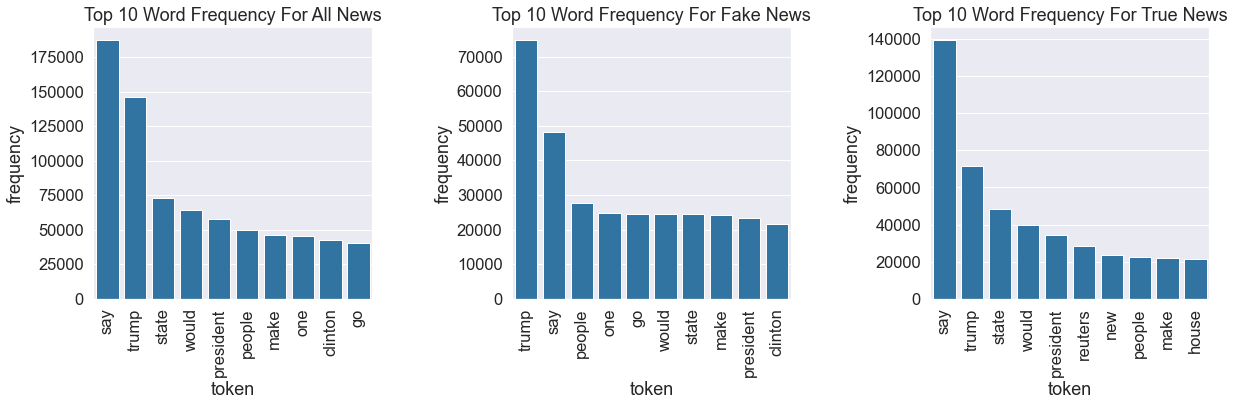

In [21]:
figs, axes = plt.subplots(nrows = 1 , ncols = 3, figsize = (20, 5))
figs.subplots_adjust(hspace=0.4, wspace=0.5)
sns.set(font_scale = 1.5)

labels = [("All", "All"), ("Fake", "Fake"), ("True", "True")]

for i, label in enumerate(labels):
    
    if label[0] == "All":
        ax = axes[i]
        dist = FreqDist(df["cleaned"].explode())
        dist_df = pd.DataFrame(dist.most_common(10),columns=["token","frequency"])

        g = sns.barplot(dist_df["token"],
                    dist_df["frequency"],
                    color ="tab:blue",
                    ax = ax)
    
        g.set_xticklabels(labels = dist_df["token"].unique(), rotation=90)
        g.set_title(f"Top 10 Word Frequency For {label[1]} News");
        
    else:    
        ax = axes[i]
        dist = FreqDist(df.loc[df["label"]==label[0],"cleaned"].explode())
        dist_df = pd.DataFrame(dist.most_common(10),columns=["token","frequency"])

        g = sns.barplot(dist_df["token"],
                    dist_df["frequency"],
                    color ="tab:blue",
                    ax = ax)
    
        g.set_xticklabels(labels = dist_df["token"].unique(), rotation=90)
        g.set_title(f"Top 10 Word Frequency For {label[1]} News");

Also one of the numerical columns that the cleaned dataframe has shows the number of url links in each news. We want to know how many news have an url link and how many links are there in the uncleaned news. The total number of raw news with url links are

In [30]:
count_urls = df.groupby("label")[["num_urls"]].count().reset_index()
count_urls.rename(columns = {"label":"label", "num_urls":"num_news_with_urls"}
                 , inplace = True)

count_urls.head()

,label,num_news_with_urls
0,Fake,26221
1,True,40181


and the distribution of the news with/without url links is:

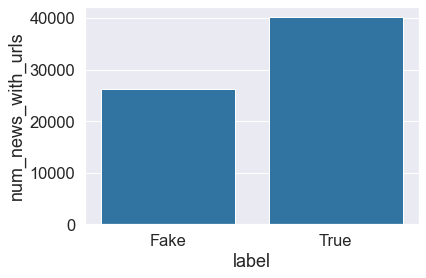

In [31]:
sns.barplot(x = "label", y = "num_news_with_urls", 
            data = count_urls, color = "tab:blue");

The total number of news used in fake and true news are 

In [32]:
num_urls = df.groupby("label")[["num_urls"]].sum().reset_index()
num_urls

,label,num_urls
0,Fake,120614
1,True,66432


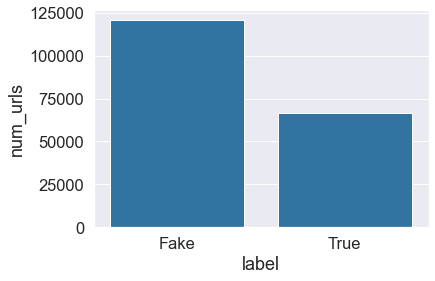

In [33]:
sns.barplot(x = "label", y = "num_urls", 
            data = num_urls, color = "tab:blue");

It seems that the more rue news relative to fake news that have url links but the total number of url links in the fake news is more that the total number of url links in the true news.

# Next

The next step is modeling the data.